In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, average_precision_score, r2_score, mean_squared_error
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

### Reading Files

In [295]:
vehicles = pd.read_csv("vehpub_2017.csv")
households = pd.read_csv("hhpub_2017.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [296]:
persons.head(10)

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,GT1JBLWK,WRK_HOME,WKFTPT,WRKTRANS,LSTTRDAY17,OCCAT,SCHTYP,NWALKTRP,WALK4EX,NBIKETRP,BIKE4EX,BIKESHARE,PTUSED,MCUSED,CARSHARE,RIDESHARE,CARRODE,TIMETOWK,NOCONG,PUBTIME,WRKTIME,WKRMHM,FLEXTIME,WKFMHMXX,SCHTRN1,SCHTRN2,DELIVER,MEDCOND,MEDCOND6,HEALTH,PHYACT,VPACT,LPACT,BORNINUS,YRTOUS,YEARMILE,PROXY,WHOPROXY,USEPUBTR,SAMEPLC,W_NONE,W_CANE,W_WLKR,W_WHCANE,W_DOG,W_CRUTCH,W_SCOOTR,W_CHAIR,W_MTRCHR,WORKER,DIARY,OUTCNTRY,FRSTHM17,CNTTDTR,GCDWORK,WKSTFIPS,DRIVER,OUTOFTWN,DISTTOWK17,DISTTOSC17,R_AGE_IMP,R_SEX_IMP,ALT_16,ALT_23,ALT_45,WALK_DEF,WALK_GKQ,BIKE_DFR,BIKE_GKP,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,HHRESP,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,67,3,2,1,2,2,6,2,-1,-1,-1,-1,-1,-1,-1,3,3,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,2,2,-1,0,1,-1,1000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.0,67,2,3,1,4,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,206.690153,T,50,1500,750,750,20,750,300
1,30000007,2,66,3,2,2,1,2,1,-1,2,2,1,6,-1,2,-1,7,0,0,-1,-1,0,-1,0,0,1,120,90,-1,08:30 PM,2,2,-1,-1,-1,5,2,-1,2,2,-1,7,1,-1,10000,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,2,2,2,58.58,37,1,2,82.61,-9.0,66,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,197.075742,T,50,1500,750,750,20,750,300
2,30000007,3,28,2,2,3,2,2,5,2,-1,-1,-1,-1,-1,-1,-1,7,0,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,2,-1,2,2,-1,2,1,-1,1000,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.0,28,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,219.514210,T,50,1500,750,750,20,750,300
3,30000008,1,55,5,2,1,1,1,1,-1,2,2,1,6,-1,4,-1,5,0,0,-1,-1,0,-1,0,0,1,10,10,-1,06:15 AM,2,2,-1,-1,-1,0,2,-1,2,3,7,-1,1,-1,12000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,2,1,2,5.53,55,1,2,8.11,-9.0,55,1,4,4,4,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,4,8,2,WI,55,2,2,201608,2,2,2,5,2,4,6,2,3,2,32,1,2,33460,2,63.185911,R,5,300,300,150,5,300,300
4,30000008,2,49,4,2,2,2,1,1,-1,2,2,1,3,1,2,-1,0,-1,0,-1,-1,0,-1,0,0,1,5,4,-1,09:00 AM,2,2,-1,-1,-1,0,2,-1,2,2,-1,7,1,-1,10000,1,2,2,10,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,0,2.22,55,1,2,3.07,-9.0,49,2,4,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,4,8,2,WI,55,2,2,201608,2,2,2,5,2,4,6,2,3,2,32,1,2,33460,2,58.665911,R,5,300,300,150,5,300,300
5,30000012,1,45,5,2,1,2,1,1,-1,2,2,1,3,-1,4,-1,6,6,0,-1,-1,0,-1,0,0,1,30,12,-1,07:30 AM,2,2,-1,-1,-1,5,2,-1,2,3,7,-1,1,-1,17000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,9,4.60,36,1,2,6.82,-9.0,45,2,3,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,1,2,10,1,NY,36,1,1,201607,1,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,58.966275,C,80,17000,17000,5000,60,17000,7000
6,30000019,1,68,1,2,1,1,1,97,2,-1,-1,-1,-1,-1,-1,-1,7,7,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,3,2,-1,3,1,-1,15000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.0,68,1,3,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,2,3,2,MD,24,2,0,201605,1,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,233.138565,S,40,300,300,150,50,750,300
7,30000019,2,66,2,2,2,2,1,4,2,-1,-1,-1,-1,-1,-1,-1,7,7,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,-1,3,2,-1,3,1,-1,5000,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,1,2,-9.00,-9,1,2,-9.00,-9.0,66,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,2,3,2,MD,24,2,0,201605,1,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,249.148185,S,40,300,300,150,50,750,300
8,30000029,1,72,3,2,1,1,1,6,2,-1,-1,-1,-1,-1,-1,-1,0,-1,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,-1,2,2,-1,1,1,-1,15000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,1,3,-9.00,-9,1,2,-9.00,-9.0,72,1,4,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3

### Data Pre-Processing
- Merged household data with vehicle data.
- Experimented with some trip data inputs with little success.

In [6]:
#trips_df = trips[trips['TRPHHVEH'] == 1][['HOUSEID', 'VEHID', 'TRVLCMIN', 'TRPMILES']].groupby(['HOUSEID', 'VEHID']).mean().reset_index()

In [297]:
vehicles = vehicles.merge(households[['HOUSEID', 'CNTTDHH', 'CAR', 'PRICE', 'PLACE']], on='HOUSEID', how='left')
#vehicles = vehicles.merge(trips_df, on=['HOUSEID', 'VEHID'], how='left')

In [299]:
vehicles['VEHTYPE'] = vehicles['VEHTYPE'].replace(5, 4)
vehicles['FUELTYPE'] = vehicles['FUELTYPE'].replace(6, 4)
vehicles_df = vehicles[(vehicles['VEHTYPE'] > 0)
                      & (vehicles['VEHTYPE'] != 6)
                      & (vehicles['VEHTYPE'] != 97)
                      & (vehicles['FUELTYPE'] > 0)
                      & (vehicles['FUELTYPE'] != 97)
                      & (vehicles['VEHAGE'] < 40)
                      & (vehicles['VEHAGE'] > 0)
                      & (vehicles['HTPPOPDN'] != -9)
                      & (vehicles['URBAN'] != 4)]
vehicles_df.loc[vehicles_df['VEHTYPE'] == 1, 'VEHTYPE'] = "Automobile"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 2, 'VEHTYPE'] = "Van"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 3, 'VEHTYPE'] = "SUV"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 4, 'VEHTYPE'] = "Truck"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 7, 'VEHTYPE'] = "Motorcycle"
vehicles_df.loc[vehicles_df['FUELTYPE'] == 1, 'FUELTYPE'] = "Gas"
vehicles_df.loc[vehicles_df['FUELTYPE'] == 2, 'FUELTYPE'] = "Diesel"
vehicles_df.loc[vehicles_df['FUELTYPE'] == 3, 'FUELTYPE'] = "Hybrid"
vehicles_df.head(10)

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,HFUEL,VEHOWNED,VEHOWNMO,ANNMILES,HYBRID,PERSONID,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTHHFIN,BESTMILE,BEST_FLG,BEST_EDT,BEST_OUT,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN,GSYRGAL,GSTOTCST,FEGEMPG,FEGEMPGA,GSCOST,FEGEMPGF,CNTTDHH,CAR,PRICE,PLACE
0,30000007,1,2007,10,49,49032,Gas,Automobile,3,69000,-1,1,-1,1000,2,3,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,14611.926637,1,-1,4,T,50,1500,750,750,20,750,300,487.064221,1126.457778,30,-9,2.312750,1,6,1,1,2
1,30000007,2,2004,13,49,49442,Gas,Van,-8,164000,-1,1,-1,2500,2,-8,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,4767.090946,3,-1,-1,T,50,1500,750,750,20,750,300,250.899523,580.267873,19,-9,2.312750,1,6,1,1,2
2,30000007,3,1998,19,19,19014,Gas,Automobile,1,120000,-1,1,-1,900,2,1,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,8000.324552,1,-1,-1,T,50,1500,750,750,20,750,300,444.462475,1027.930589,18,-9,2.312750,1,6,1,1,2
3,30000007,4,1997,20,19,19021,Gas,Automobile,2,-88,-1,1,-1,500,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,725.932347,2,-1,-1,T,50,1500,750,750,20,750,300,40.329575,93.272224,18,-9,2.312750,1,6,1,1,2
4,30000007,5,1993,24,20,20481,Gas,Truck,2,300000,-1,1,-1,10000,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,12437.658757,1,-1,-1,T,50,1500,750,750,20,750,300,888.404197,2054.656806,14,-9,2.312750,1,6,1,1,2
9,30000012,1,2011,6,58,58037,Gas,Automobile,1,70115,-1,1,-1,11000,2,1,5,1,1,2,10,1,NY,36,1,1,201607,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,79.419586,4616.917047,1,-1,-1,C,80,17000,17000,5000,60,17000,7000,219.853193,542.011404,21,-9,2.465333,1,9,1,2,1
10,30000012,2,2004,13,12,12473,Gas,SUV,1,68204,-1,1,-1,6000,2,1,5,1,1,2,10,1,NY,36,1,1,201607,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,79.419586,4002.551052,1,-1,-1,C,80,17000,17000,5000,60,17000,7000,250.159441,616.726408,16,-9,2.465333,1,9,1,2,1
11,30000019,1,2006,11,37,37032,Gas,Automobile,1,120000,-1,1,-1,10000,2,1,5,1,2,2,3,2,MD,24,2,0,201605,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,279.143588,7027.686033,1,-1,-1,S,40,300,300,150,50,750,300,305.551567,745.596748,23,-9,2.440167,1,4,1,2,3
12,30000019,2,1997,20,21,21001,Gas,Automobile,1,135000,-1,1,-1,5000,2,1,5,1,2,2,3,2,MD,24,2,0,201605,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,279.143588,12833.557760,1,-1,-1,S,40,300,300,150,50,750,300,641.677888,1565.800993,20,-9,2.440167,1,4,1,2,3
13,30000029,1,2016,1,49,49402,Gas,SUV,1,8774,-1,2,5,21058,2,1,3,1,2,2,5,2,WI,55,2,0,201610,10,3,3,2,1,2,1,3,2,33,1,2,XXXXX,2,103.240304,14029.079480,1,-1,-1,S,40,1500,750,750,40,1500,750,561.163179,1271.876346,25,-9,2.266500,1,10,1,3,2


### Basic Metadata

In [212]:
len(vehicles_df)

175546

In [213]:
vehicles_df['VEHTYPE'].value_counts(normalize=True)

VEHTYPE
Automobile    0.519163
SUV           0.249695
Truck         0.146417
Van           0.053559
Motorcycle    0.031166
Name: proportion, dtype: float64

In [214]:
vehicles_df['FUELTYPE'].value_counts(normalize=True)

FUELTYPE
Gas       0.952001
Hybrid    0.029160
Diesel    0.018838
Name: proportion, dtype: float64

## Predicting Vehicle Type
- Random Forest Model

### Split Data Into Training & Test Splits

In [215]:
X = vehicles_df[['CNTTDHH', 'HTPPOPDN', 'HHSIZE', 'HHVEHCNT', 'DRVRCNT']]
y = vehicles_df['VEHTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Hyperparameter Tuning

In [ ]:
param_dist = {'n_estimators': randint(250, 750), 'max_depth': randint(50, 150)}
rfc = RandomForestClassifier(class_weight='balanced')
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(X_train, y_train)

In [ ]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:', rand_search.best_params_)

### Run Model 

In [216]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train);

In [217]:
#pipeline = Pipeline([('model', rf_model)])
#pipeline.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

  Automobile       0.61      0.36      0.46     18272
  Motorcycle       0.10      0.66      0.18      1098
         SUV       0.29      0.24      0.26      8831
       Truck       0.19      0.21      0.20      5015
         Van       0.09      0.21      0.13      1894

    accuracy                           0.31     35110
   macro avg       0.26      0.34      0.24     35110
weighted avg       0.43      0.31      0.34     35110



In [218]:
pd.Series(y_pred).value_counts(normalize=True)

Automobile    0.311421
SUV           0.205810
Motorcycle    0.204415
Truck         0.157619
Van           0.120735
Name: proportion, dtype: float64

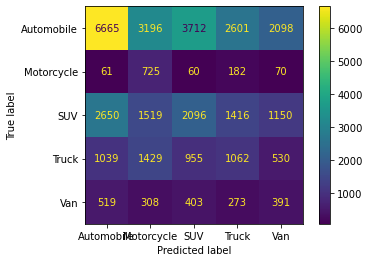

In [219]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van']).plot();

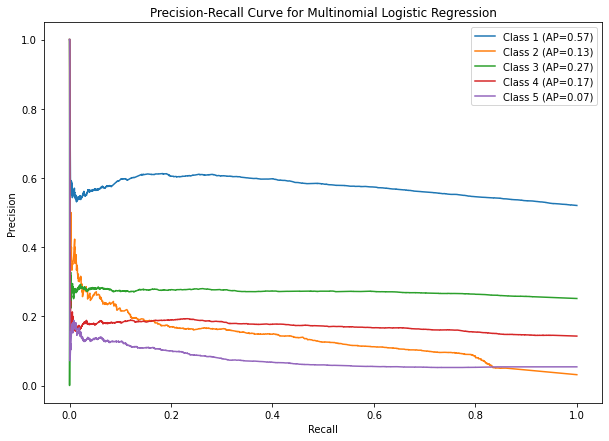

In [221]:
y_prob = rf_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 6):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(10, 7))

for i in range(1, 6):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multinomial Logistic Regression')
plt.legend()
plt.show()

## Predicting Vehicle Fuel Type
- Random Forest Model

In [287]:
X = vehicles_df[['CNTTDHH', 'CDIVMSAR', 'HTPPOPDN', 'HHSIZE', 'MSASIZE', 'HHFAMINC']]
y = vehicles_df['FUELTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [288]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train);

In [289]:
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

      Diesel       0.05      0.18      0.08       655
         Gas       0.96      0.86      0.91     33458
      Hybrid       0.08      0.21      0.11       997

    accuracy                           0.83     35110
   macro avg       0.36      0.42      0.37     35110
weighted avg       0.92      0.83      0.87     35110



In [290]:
pd.Series(y_pred).value_counts(normalize=True)

Gas       0.854885
Hybrid    0.077044
Diesel    0.068072
Name: proportion, dtype: float64

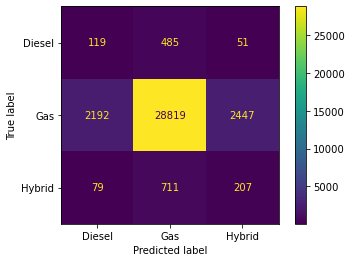

In [291]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Diesel', 'Gas', 'Hybrid']).plot();

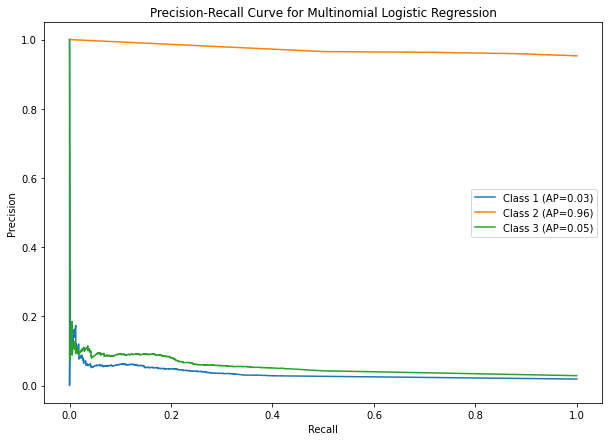

In [293]:
y_prob = rf_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Diesel', 'Gas', 'Hybrid'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 4):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(10, 7))

for i in range(1, 4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multinomial Logistic Regression')
plt.legend()
plt.show()

## Predicting Vehicle Age
- Multiple Linear Regression Model

In [300]:
X = vehicles_df[['CNTTDHH', 'DRVRCNT', 'LIF_CYC']]
y = vehicles_df['VEHAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [301]:
lr_model = LinearRegression()
#lr_model.fit(X_train, y_train);

In [302]:
oversample = RandomOverSampler()
pipeline = Pipeline([('over', oversample), ('model', lr_model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

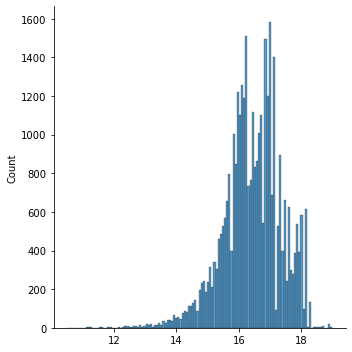

In [303]:
y_pred = lr_model.predict(X_test)
sns.displot(y_pred);

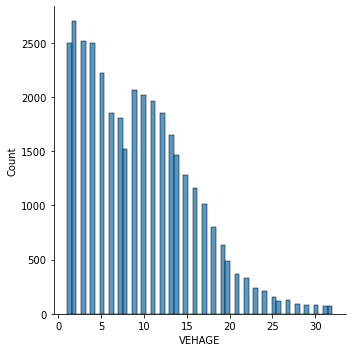

In [304]:
sns.displot(y_test)

In [305]:
score = r2_score(y_test, y_pred)
print('R2:',score)
print('MSE: ',mean_squared_error(y_test, y_pred))

R2: -1.2615701525650302
MSE:  90.37101101975762


In [306]:
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                 VEHAGE   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     146.8
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           5.55e-95
Time:                        18:56:55   Log-Likelihood:            -4.6908e+05
No. Observations:              143660   AIC:                         9.382e+05
Df Residuals:                  143656   BIC:                         9.382e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5788      0.050    192.102      0.0